In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import pandas as pd
import cobra
import pytfa
import numpy as np

from optlang.exceptions import SolverError

#from cobra.core.model import SolverNotFound
from cobra.flux_analysis import flux_variability_analysis
from cobra.io import load_matlab_model, load_json_model


from pytfa.io import import_matlab_model, load_thermoDB,                    \
                            read_lexicon, annotate_from_lexicon,            \
                            read_compartment_data, apply_compartment_data
from pytfa.optim.relaxation import relax_dgo

import pickle
from pytfa.optim.variables import LogConcentration
#thermo_database = '/projectnb2/bioinfor/SEGRE/goldford/CoenzymeSpecificity/pytfa/data/thermo_data.thermodb'
#root_dir = '/projectnb/bioinfor/SEGRE/goldford/CoenzymeSpecificity/pytfa/tests/singleCoenzymeModel.08272021.v2'
thermo_database = '../assets/thermo_data.thermodb'
model_path = '../assets'

CPLEX = 'optlang-cplex'
GUROBI = 'optlang-gurobi'
GLPK = 'optlang-glpk'
solver = GUROBI

# Load reaction DB
print("Loading thermo data...")
thermo_data = load_thermoDB(thermo_database)

print("Done !")
#biomass_rxn = 'BIOMASS_Ec_iJO1366_WT_53p95M'
biomass_rxn = 'Ec_biomass_iJO1366_WT_53p95M'


model_id = 'iJO1366_WT_semi-unconstrained.json'
#model_id = 'iJO1366.json'

# We import pre-compiled data as it is faster for bigger models
cobra_model = load_json_model(model_path + '/' + model_id)



Academic license - for non-commercial use only - expires 2022-08-19
Using license file /Users/joshuagoldford/gurobi.lic
Loading thermo data...
Done !


In [2]:
from copy import deepcopy
def removeDuplicateRxn(model):
	model2 = deepcopy(model)
	toRemove = []
	for eachReaction in model2.reactions:

		if eachReaction.id in toRemove:
			continue

		ids = []
		stechiometry = []
		for eachMet in eachReaction.metabolites:
			ids.append(eachMet.id)
			stechiometry.append(eachReaction.metabolites[eachMet])

		removedEachReaction = 0
		for eachReaction2 in model2.reactions:
			if eachReaction2 == eachReaction or eachReaction2.id in toRemove or len(eachReaction2.metabolites) != len(eachReaction.metabolites):
				continue
			
			duplicate = 1
			for eachMet in eachReaction2.metabolites:
			
				if eachMet.id not in ids:
					duplicate = 0
					break
					
				if abs(eachReaction2.metabolites[eachMet]) != abs(stechiometry[ids.index(eachMet.id)]):
					duplicate = 0
					break
			
			if duplicate == 1:
				
				if len(eachReaction2.genes) == 0 and len(eachReaction.genes) == 0:
					if eachReaction2.lower_bound < eachReaction.lower_bound:
						toRemove.append(eachReaction.id)
						removedEachReaction = 1
					else:
						toRemove.append(eachReaction2.id)
				
				elif len(eachReaction2.genes) == 0 and len(eachReaction.genes) != 0:
					toRemove.append(eachReaction.id)
					removedEachReaction = 1
					
				elif len(eachReaction2.genes) != 0 and len(eachReaction.genes) == 0:
					toRemove.append(eachReaction2.id)
				
				elif len(eachReaction2.genes) != 0 and len(eachReaction.genes) != 0:
					
					totalGenes = []
					for eachGene in eachReaction2.genes:
						totalGenes.append(eachGene.id)
					for eachGene in eachReaction.genes:
						if eachGene.id not in totalGenes:
							totalGenes.append(eachGene.id)
				
					if eachReaction2.lower_bound < eachReaction.lower_bound:
						toRemove.append(eachReaction.id)
						if len(eachReaction2.genes) != len(totalGenes):
							string = ''
							for i in range(len(totalGenes)):
								string = string + totalGenes[i]
								if i != len(totalGenes) -1:
									string = string + " or "
							eachReaction2.gene_reaction_rule = '( ' + string +' )'
						removedEachReaction = 1
					else:
						toRemove.append(eachReaction2.id)
						if len(eachReaction.genes) != len(totalGenes):
							string = ''
							for i in range(len(totalGenes)):
								string = string + totalGenes[i]
								if i != len(totalGenes) -1:
									string = string + " or "
							eachReaction.gene_reaction_rule = '( ' + string +' )'
							
				
			if removedEachReaction == 1:
				break
		

	model2.remove_reactions(toRemove)
	
	return [model2, toRemove]

In [4]:
#cobra_model = load_json_model(model_path + '/' + model_id)
exchange_rxns = [x.id for x in  cobra_model.reactions if x.id[0:3] == 'DM_']
lb = []
ub = []
for e in exchange_rxns:
    #cobra_model.reactions.get_by_id(e).lower_bound = 0
    lb.append(cobra_model.reactions.get_by_id(e).lower_bound )
    ub.append(cobra_model.reactions.get_by_id(e).upper_bound )
    
bounds = pd.DataFrame({'exchange': exchange_rxns, 'lb': lb, 'ub':ub})

In [5]:
changeMedia = False
if changeMedia:
    carbon_source = 'DM_glc_e'
    oxygen = True
    carbon_flux = 10
    cobra_model.reactions.get_by_id('DM_glc_e').lower_bound = 0

    cobra_model.reactions.get_by_id(carbon_source).lower_bound = -carbon_flux
    if oxygen:
        cobra_model.reactions.get_by_id('DM_o2_e').lower_bound = -1000
    else:
        cobra_model.reactions.get_by_id('DM_o2_e').lower_bound = 0


In [6]:
lb = []
ub = []
exchange_rxns = [x.id for x in  cobra_model.reactions if x.id[0:3] == 'DM_']

for e in exchange_rxns:
    #cobra_model.reactions.get_by_id(e).lower_bound = 0
    lb.append(cobra_model.reactions.get_by_id(e).lower_bound )
    ub.append(cobra_model.reactions.get_by_id(e).upper_bound )
    
bounds = pd.DataFrame({'exchange': exchange_rxns, 'lb': lb, 'ub':ub})

In [7]:
#bounds.iloc[21:40]

In [8]:
#.slim_optimize()


In [9]:
#medium = ecoli.medium
#medium.pop('EX_glc__D_e')
#medium['EX_pyr_e'] = 10
#ecoli.medium = medium

In [10]:
cobra_model.slim_optimize()

24.71368225863309

In [11]:
lexicon = read_lexicon(model_path + '/iJO1366/lexicon.csv')
compartment_data = read_compartment_data(model_path + '/iJO1366/compartment_data.json')

# Initialize the cobra_model
mytfa = pytfa.ThermoModel(thermo_data, cobra_model)

# Annotate the cobra_model
annotate_from_lexicon(mytfa, lexicon)
apply_compartment_data(mytfa, compartment_data)


mytfa.name = 'iJO1366[WT]'
mytfa.solver = solver
mytfa.objective = biomass_rxn

# Solver settings

def apply_solver_settings(model, solver = solver):
    model.solver = solver
    # model.solver.configuration.verbosity = 1
    model.solver.configuration.tolerances.feasibility = 1e-9
    if solver == 'optlang_gurobi':
        model.solver.problem.Params.NumericFocus = 3
    model.solver.configuration.presolve = True

apply_solver_settings(mytfa)


## FBA
fba_solution = cobra_model.optimize()
fba_value = fba_solution.objective_value
print('FBA Solution found : {0:.5g}'.format(fba_value))

# fva = flux_variability_analysis(mytfa)

## TFA conversion
mytfa.prepare()
mytfa.convert()#add_displacement = True)

## Info on the cobra_model
mytfa.print_info()

## Optimality
tfa_solution = mytfa.optimize()
tfa_value = tfa_solution.objective_value
print('TFA Solution found : {0:.5g}'.format(tfa_value))

# It might happen that the model is infeasible. In this case, we can relax 
# thermodynamics constraints:

if tfa_value < 0.01:
    
    from pytfa.optim.relaxation import relax_dgo
    #mytfa.reactions.get_by_id(biomass_rxn).lower_bound = 0.5*fba_value
    mytfa.reactions.get_by_id(biomass_rxn).lower_bound = 0.5
    relaxed_model, slack_model, relax_table = relax_dgo(mytfa)
    original_model, mytfa = mytfa, relaxed_model
    print('Relaxation: ')
    print(relax_table)
    
    tfa_solution = mytfa.optimize()
    tfa_value = tfa_solution.objective_value

    print('relaxed TFA Solution found : {0:.5g}'.format(tfa_value))

# Report
print('FBA Solution found : {0:.5g}'.format(fba_value))
print('TFA Solution found : {0:.5g}'.format(tfa_value))

double_coenzyme_models = {}
z = mytfa.copy()
double_coenzyme_models['tmodel'] = z
double_coenzyme_models['tmodel-maxGrowth'] = tfa_value
double_coenzyme_models['tmodel-solution'] = tfa_solution

Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpo2t3cy95.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20334 nonzeros


2021-12-03 20:27:46,020 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2021-12-03 20:27:46,124 - thermomodel_None - INFO - # Model preparation starting...


FBA Solution found : 24.714


2021-12-03 20:27:48,300 - thermomodel_None - WARNING - Warning : NULL/U
2021-12-03 20:27:48,301 - thermomodel_None - WARNING - Warning : NULL/L
2021-12-03 20:27:48,302 - thermomodel_None - WARNING - Warning : NULL/L
2021-12-03 20:27:48,303 - thermomodel_None - WARNING - Warning : NULL/U
2021-12-03 20:27:48,304 - thermomodel_None - WARNING - Warning : NULL/L
2021-12-03 20:27:48,305 - thermomodel_None - WARNING - Warning : NULL/L
2021-12-03 20:27:48,494 - thermomodel_None - WARNING - Warning : NULL/U
2021-12-03 20:27:48,495 - thermomodel_None - WARNING - Warning : NULL/L
2021-12-03 20:27:48,496 - thermomodel_None - WARNING - Warning : NULL/L
2021-12-03 20:27:48,496 - thermomodel_None - WARNING - Warning : NULL/U
2021-12-03 20:27:48,498 - thermomodel_None - WARNING - Warning : NULL/L
2021-12-03 20:27:48,498 - thermomodel_None - WARNING - Warning : NULL/L
2021-12-03 20:27:48,627 - thermomodel_None - WARNING - Warning : NULL/U
2021-12-03 20:27:48,627 - thermomodel_None - WARNING - Warning :

                       value
key                         
name             iJO1366[WT]
description      iJO1366[WT]
num constraints        15034
num variables          15538
num metabolites         1807
num reactions           2585
                             value
key                               
num metabolites(thermo)       1550
num reactions(thermo)         1824
pct metabolites(thermo)  85.777532
pct reactions(thermo)    70.560928
TFA Solution found : 0
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp2rbhe8xd.lp
Reading time = 0.01 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-12-03 20:28:38,298 - thermomodel_iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpjt6gn_3h.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-12-03 20:28:55,158 - thermomodel_iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2021-12-03 20:29:05,001 - thermomodel_iJO1366[WT] - INFO - Adding slack constraints
adding slacks: 100%|██████████| 1824/1824 [00:46<00:00, 39.10it/s]
2021-12-03 20:29:53,052 - thermomodel_iJO1366[WT] - INFO - Optimizing slack model
2021-12-03 20:30:00,007 - thermomodel_iJO1366[WT] - INFO - Extracting relaxation
applying slack: 100%|██████████| 2585/2585 [00:00<00:00, 116968.48it/s]
2021-12-03 20:30:00,113 - thermomodel_iJO1366[WT] - INFO - Testing relaxation


Relaxation: 
              lb_in      ub_in  lb_change  ub_change     lb_out     ub_out
AIRC3    -11.941085  -8.988685   0.000000   2.582409 -11.941085  -6.406276
ARGSL     16.770653  18.636729   2.184361   0.000000  14.586293  18.636729
ATPS4rpp  -9.518201  -8.083092   1.452217   0.000000 -10.970418  -8.083092
GALT1     67.754735  69.018800  54.942183   0.000000  12.812552  69.018800
HEPK2     44.872230  45.345690  32.059679   0.000000  12.812552  45.345690
HEPT1     25.810459  27.074524  13.693847   0.000000  12.116612  27.074524
MECDPS    26.135683  30.646876  11.549390   0.000000  14.586293  30.646876
MTHTHFSs  13.297862  14.814659   6.891586   0.000000   6.406276  14.814659
PRAIS     17.442418  22.161249   0.065725   0.000000  17.376694  22.161249
relaxed TFA Solution found : 0.838
FBA Solution found : 24.714
TFA Solution found : 0.838
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpnb2xfsmd.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 column

2021-12-03 20:30:31,550 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [13]:
relax_table.to_csv('pyTFA.relaxation.csv')

              lb_in      ub_in  lb_change  ub_change     lb_out     ub_out
AIRC3    -11.941085  -8.988685   0.000000   2.582409 -11.941085  -6.406276
ARGSL     16.770653  18.636729   2.184361   0.000000  14.586293  18.636729
ATPS4rpp  -9.518201  -8.083092   1.452217   0.000000 -10.970418  -8.083092
GALT1     67.754735  69.018800  54.942183   0.000000  12.812552  69.018800
HEPK2     44.872230  45.345690  32.059679   0.000000  12.812552  45.345690
HEPT1     25.810459  27.074524  13.693847   0.000000  12.116612  27.074524
MECDPS    26.135683  30.646876  11.549390   0.000000  14.586293  30.646876
MTHTHFSs  13.297862  14.814659   6.891586   0.000000   6.406276  14.814659
PRAIS     17.442418  22.161249   0.065725   0.000000  17.376694  22.161249
relaxed TFA Solution found : 0.838
FBA Solution found : 24.714
TFA Solution found : 0.838
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6

In [73]:
rxn_nad = [x for x in gene_set.reaction.tolist() if x in tfa_solution_wt.fluxes.index]

In [77]:
pd.DataFrame(tfa_solution_wt.fluxes.loc[rxn_nad]).sort_values('fluxes')

,fluxes
GLUDy,-6.377732
GLYCDx,-3.313450
ME1,-2.008863
KARA1,-0.711911
GLYCL,-0.576520
...,...
PDH,2.966708
G3PD2,3.177993
GAPD,10.027444
GND,11.875626


In [102]:
S = cobra.util.array.create_stoichiometric_matrix(cobra_model)
met_names = [x.id for x in cobra_model.metabolites]
rxn_names = [x.id for x in cobra_model.reactions]
S = pd.DataFrame(S,index=met_names,columns=rxn_names)

In [112]:
g = S[rxn_nad].T.any()
mets_involved = g[g].index.tolist()
S_n = S.loc[mets_involved][rxn_nad]

<AxesSubplot:>

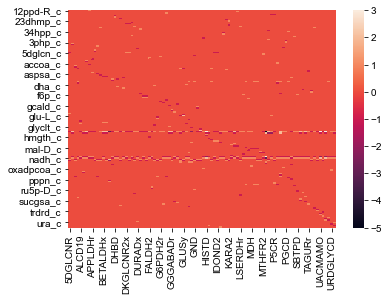

In [119]:
sns.heatmap(S_n)

In [9]:
def single_coenzyme_transform(model,reaction_id):
    
    met = {}
    met['nad'] = np.where([x.id == 'nad_c' for x in model.metabolites])[0][0]
    met['nadp'] = np.where([x.id == 'nadp_c' for x in model.metabolites])[0][0]
    met['nadh'] = np.where([x.id == 'nadh_c' for x in model.metabolites])[0][0]
    met['nadph'] = np.where([x.id == 'nadph_c' for x in model.metabolites])[0][0]

    met_objs = {}
    met_objs['nad'] = [x for x in model.metabolites if x.id == 'nad_c'][0]
    met_objs['nadh'] = [x for x in model.metabolites if x.id == 'nadh_c'][0]
    met_objs['nadp'] = [x for x in model.metabolites if x.id == 'nadp_c'][0]
    met_objs['nadph'] = [x for x in model.metabolites if x.id == 'nadph_c'][0]
    
    rxn = [x for x in model.reactions if x.id == reaction_id][0].copy()
    # make a new dictionary with coenzyme swapped
    v = {x:y for x,y in rxn.metabolites.items() if x.id in [x + '_c' for x in list(met)]}
    
    nad_stoich = 0;
    nadh_stoich  = 0;
    set([x.id for x in m.reactions.get_by_id(rxnid).metabolites])
    if len(v) > 1:
        v2 = {}
        for x,y in v.items():
            if x.id == 'nadph_c':
                nadh_stoich = nadh_stoich + y 
                #v2[met_objs['nadh']] = y
            elif x.id == 'nadp_c':
                nad_stoich = nad_stoich + y 
                #v2[met_objs['nad']] = y
            elif x.id == 'nadh_c':
                nadh_stoich = nadh_stoich + y 
                #v2[met_objs['nadph']] = y
            elif x.id == 'nad_c':
                nad_stoich = nad_stoich + y 
                #v2[met_objs['nadp']] = y

        v2[met_objs['nad']] = nad_stoich
        v2[met_objs['nadh']] = nadh_stoich

        rxn.subtract_metabolites(v)
        rxn.add_metabolites(v2)
        #rxn.id = rxn.id + '[condensed]'
        # keep old reaction ID
        #print('adding new reaction '+ rxn.id)
        model.remove_reactions([x for x in model.reactions if x.id == reaction_id][0])
        model.add_reaction(rxn)
        coverted = True
        return model,coverted
    else:
        coverted = False
        return model,coverted

In [10]:
m  = z.copy()

rxns_to_remove = ['NADTRHD','NADPPPS','NADK','THD2pp']
rxn_ids = [x.id for x in m.reactions]

#m.remove_reactions([x for x in m.reactions if x.id == 'NADTRHD'][0])
#m.remove_reactions([x for x in m.reactions if x.id == 'NADPPPS'][0])
#m.remove_reactions([x for x in m.reactions if x.id == 'NADK'][0])
#m.remove_reactions([x for x in m.reactions if x.id in rxns_to_remove][0])

m.remove_reactions(rxns_to_remove)

rxn_ids = [x for x in rxn_ids if x not in rxns_to_remove]
#rxn_ids = [x for x in rxn_ids if x not in ['Ec_biomass_iJO1366_WT_53p95M','Ec_biomass_iJO1366_core_53p95M']]

converted_rxns = []
for rxnid in rxn_ids:
    m,conv = single_coenzyme_transform(m,rxnid)
    if conv:
        converted_rxns.append(rxnid)

        
#m.remove_reactions([x for x in m.reactions if x.id == 'NADTRHD[condensed]'][0])
#m.remove_reactions([x for x in m.reactions if x.id == 'NADPPPS[condensed]'][0])
#m.remove_reactions([x for x in m.reactions if x.id == 'NADK[condensed]'][0])
#m.remove_reactions([x for x in m.reactions if x.id == 'NADDP'][0])

m.id = 'iJO1366[NAD]'
#m.objective = 'BIOMASS_Ec_iJO1366_WT_53p95M'
m.objective = 'Ec_biomass_iJO1366_WT_53p95M'
m.name = 'RelaxedModel iJO1366[NAD]'
m.description = 'RelaxedModel iJO1366[NAD]'

met_objs = {}
met_objs['nad'] = [x for x in m.metabolites if x.id == 'nad_c'][0]
met_objs['nadh'] = [x for x in m.metabolites if x.id == 'nadh_c'][0]
met_objs['nadp'] = [x for x in m.metabolites if x.id == 'nadp_c'][0]
met_objs['nadph'] = [x for x in m.metabolites if x.id == 'nadph_c'][0]
#m.remove_metabolites([met_objs['nadp'],met_objs['nadph']])
m,unusedmets = cobra.manipulation.delete.prune_unused_metabolites(m)

Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmplrqrdvxl.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 15:56:12,583 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
/Users/joshuagoldford/opt/miniconda3/envs/coenzymes/lib/python3.8/site-packages/cobra/core/model.py:745: UserWarning: need to pass in a list
  warn("need to pass in a list")


Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp4eyfzg7_.lp
Reading time = 0.02 seconds
: 1807 rows, 5162 columns, 20260 nonzeros


2021-10-28 15:57:09,520 - thermomodel_RelaxedModel iJO1366[NAD] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [11]:
sc_model, removedReactions = removeDuplicateRxn(m)

Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpy6ji62wv.lp
Reading time = 0.02 seconds
: 1805 rows, 5162 columns, 20260 nonzeros


2021-10-28 16:03:05,111 - thermomodel_RelaxedModel iJO1366[NAD] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [12]:
## re-prepare the TFA model
sc_model.prepare()
sc_model.convert()#add_displacement = True)
## Info on the cobra_model
sc_model.print_info()

2021-10-28 16:03:21,621 - thermomodel_RelaxedModel iJO1366[NAD] - INFO - # Model preparation starting...
2021-10-28 16:03:23,753 - thermomodel_RelaxedModel iJO1366[NAD] - WARNING - Warning : NULL/U
2021-10-28 16:03:23,753 - thermomodel_RelaxedModel iJO1366[NAD] - WARNING - Warning : NULL/L
2021-10-28 16:03:23,754 - thermomodel_RelaxedModel iJO1366[NAD] - WARNING - Warning : NULL/L
2021-10-28 16:03:23,755 - thermomodel_RelaxedModel iJO1366[NAD] - WARNING - Warning : NULL/U
2021-10-28 16:03:23,755 - thermomodel_RelaxedModel iJO1366[NAD] - WARNING - Warning : NULL/L
2021-10-28 16:03:23,756 - thermomodel_RelaxedModel iJO1366[NAD] - WARNING - Warning : NULL/L
2021-10-28 16:03:23,870 - thermomodel_RelaxedModel iJO1366[NAD] - WARNING - Warning : NULL/U
2021-10-28 16:03:23,871 - thermomodel_RelaxedModel iJO1366[NAD] - WARNING - Warning : NULL/L
2021-10-28 16:03:23,871 - thermomodel_RelaxedModel iJO1366[NAD] - WARNING - Warning : NULL/L
2021-10-28 16:03:23,872 - thermomodel_RelaxedModel iJO1366

                                     value
key                                       
name             RelaxedModel iJO1366[NAD]
description      RelaxedModel iJO1366[NAD]
num constraints                      14714
num variables                        15200
num metabolites                       1805
num reactions                         2523
                             value
key                               
num metabolites(thermo)       1548
num reactions(thermo)         1780
pct metabolites(thermo)  85.761773
pct reactions(thermo)    70.550931


In [13]:
tfa_solution_sc = sc_model.optimize()
tfa_value_sc = tfa_solution_sc.objective_value
# Report
print('TFA Solution found : {0:.5g}'.format(tfa_value_sc))

TFA Solution found : 0.72479


In [14]:
tfa_solution_wt = z.optimize()
tfa_value_wt = tfa_solution_wt.objective_value
# Report
print('TFA Solution found : {0:.5g}'.format(tfa_value_wt))

TFA Solution found : 0.838


In [53]:
#tfa_solution_sc.fluxes.to_csv('tfa.sc.pyruvate.fluxes.21Oct2021.csv')
#tfa_solution_wt.fluxes.to_csv('tfa.wt.pyruvate.fluxes.21Oct2021.csv')

In [15]:
tfa_res = pd.DataFrame({'model': ['WT','SC'], 'max growth rate' : [tfa_value_wt,tfa_value_sc]})

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

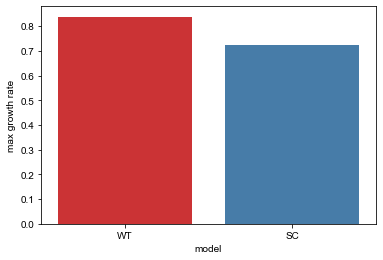

In [20]:
sns.barplot(x='model',y='max growth rate',data=tfa_res,palette='Set1')
#plt.title('iJO1366')
plt.savefig('iJO1366.wt_sc.glucose.barplot.svg')

In [103]:
#help(m.optimize())
sol_pfba = cobra.flux_analysis.pfba(m)

In [21]:
m.description = 'RelaxedModel iJO1366[NAD]'

<AxesSubplot:xlabel='WT', ylabel='SC'>

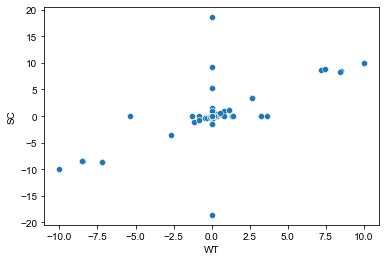

In [54]:
wt_fluxes = pd.DataFrame(tfa_solution_wt.fluxes)
sc_fluxes = pd.DataFrame(tfa_solution_sc.fluxes)
wt_fluxes.columns = ['WT']
sc_fluxes.columns = ['SC']
res = wt_fluxes.join(sc_fluxes)
sns.scatterplot(x='WT',y='SC',data=res)
#plt.xlim([-40,40])
#plt.ylim([-40,40])


In [34]:
res = wt_fluxes.join(sc_fluxes)

In [139]:
reaction_ids = pd.DataFrame(tfa_solution.fluxes).index.tolist()
reaction_ids = [x for x in reaction_ids if x[0:2] != 'DM']
reaction_ids = [x for x in reaction_ids if x not in ['Ec_biomass_iJO1366_WT_53p95M','Ec_biomass_iJO1366_core_53p95M']]


In [144]:
# change flux bounds to 100
wt_model = z.copy()
sc_model = m.copy()

Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmppy921hyg.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-19 11:01:57,670 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpx305l9wn.lp
Reading time = 0.01 seconds
: 1805 rows, 5162 columns, 20260 nonzeros


2021-10-19 11:02:12,830 - thermomodel_RelaxedModel iJO1366[NAD] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [156]:
fb = 100
wt_rxns = [x.id for x in wt_model.reactions]
sc_rxns = [x.id for x in sc_model.reactions]

for r in reaction_ids:
    if r in wt_rxns:
        lb = wt_model.reactions.get_by_id(r).lower_bound
        ub = wt_model.reactions.get_by_id(r).upper_bound
        if ub > fb:
            ub = fb
        if lb < -fb:
            lb = -fb
            
        wt_model.reactions.get_by_id(r).lower_bound = lb
        wt_model.reactions.get_by_id(r).upper_bound = ub
        
    if r in sc_rxns:
        lb = sc_model.reactions.get_by_id(r).lower_bound
        ub = sc_model.reactions.get_by_id(r).upper_bound
        if ub > fb:
            ub = fb
        if lb < -fb:
            lb = -fb
            
        sc_model.reactions.get_by_id(r).lower_bound = lb
        sc_model.reactions.get_by_id(r).upper_bound = ub

In [197]:
wt_model.reactions.get_by_id('ATPM').lower_bound = 0
sc_model.reactions.get_by_id('ATPM').lower_bound = 0

In [198]:
tfa_solution_wt = wt_model.optimize()
tfa_value_wt = tfa_solution_wt.objective_value
# Report
print('TFA Solution found for WT model : {0:.5g}'.format(tfa_value_wt))

tfa_solution_sc = sc_model.optimize()
tfa_value_sc = tfa_solution_sc.objective_value
# Report
print('TFA Solution found for SC model : {0:.5g}'.format(tfa_value_sc))

TFA Solution found for WT model : 0.83799
TFA Solution found for SC model : 0.72478


In [22]:
gene_set = pd.read_csv('../../assets/EC_1.X.1.X.Unique_NAD(P)_Coupled.GeneSet.Thermo.csv')

In [23]:
def swap_reaction_rid(model,reaction_id):
    met = {}
    met['nad'] = np.where([x.id == 'nad_c' for x in model.metabolites])[0][0]
    met['nadp'] = np.where([x.id == 'nadp_c' for x in model.metabolites])[0][0]
    met['nadh'] = np.where([x.id == 'nadh_c' for x in model.metabolites])[0][0]
    met['nadph'] = np.where([x.id == 'nadph_c' for x in model.metabolites])[0][0]

    met_objs = {}
    met_objs['nad'] = [x for x in model.metabolites if x.id == 'nad_c'][0]
    met_objs['nadh'] = [x for x in model.metabolites if x.id == 'nadh_c'][0]
    met_objs['nadp'] = [x for x in model.metabolites if x.id == 'nadp_c'][0]
    met_objs['nadph'] = [x for x in model.metabolites if x.id == 'nadph_c'][0]
    
    rxn = model.reactions.get_by_id(reaction_id).copy()
    # make a new dictionary with coenzyme swapped
    v = {x:y for x,y in rxn.metabolites.items() if x.id in [x + '_c' for x in list(met)]}

    v2 = {}
    for x,y in v.items():
        if x.id == 'nadph_c':
            v2[met_objs['nadh']] = y
        elif x.id == 'nadp_c':
            v2[met_objs['nad']] = y
        elif x.id == 'nadh_c':
            v2[met_objs['nadph']] = y
        elif x.id == 'nad_c':
            v2[met_objs['nadp']] = y
            
    rxn.subtract_metabolites(v)
    rxn.add_metabolites(v2)
    rxn.id = rxn.id + '[mutant]'
    model.remove_reactions([reaction_id])
    model.add_reaction(rxn)
    return model

In [25]:
wt_model = z.copy()
wt = wt_model.copy()

Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmplpckdxlu.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:08:51,044 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpynsc2za1.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:09:10,618 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [26]:
results_sgm_tfa = {'gene': [], 'growth_rate': []}
for gene,dfn in gene_set.groupby('gene'):
    m = wt_model.copy()
    for idx,row in dfn.iterrows():
        if row.reaction in [x.id for x in m.reactions]:
            #j = np.where([x.id == row.reaction for x in m.reactions])[0][0]
            # swap reaction, keep direction from wild type reaction
            m = swap_reaction_rid(m,row.reaction)
            
    #m.id = m.id + '_' + gene + '_' + dfn['mutant coenzyme'].tolist()[0].split('(')[0]
    v = m.slim_optimize()
    results_sgm_tfa['gene'].append(gene)
    results_sgm_tfa['growth_rate'].append(v)
    print('done with gene: ' + dfn.gene_name.tolist()[0])

Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpcgzs3x9v.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:09:43,154 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: dapB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmptdortaoa.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:10:35,186 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: pdxA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpyd2k2tl7.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:12:45,484 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: leuB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpfgp8guqp.lp
Reading time = 0.01 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:15:15,902 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: guaC
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp3o1b7dhb.lp
Reading time = 0.03 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:16:04,894 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: lpd
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpfvn3w96z.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:16:40,015 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: dxr
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpfmd25bpo.lp
Reading time = 0.01 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:17:08,152 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: proA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpv4dxpze_.lp
Reading time = 0.01 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:17:42,224 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: betB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp9kyfgms4.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:18:00,197 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: frmA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpgaii4gnw.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:18:35,591 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: proC
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp_klog86o.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:18:53,688 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: ribD
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpmz5a5bxe.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:19:38,276 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: allD
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpbh21g14f.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:20:05,490 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: folD
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmplf3offzl.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:20:54,259 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: entA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpmqz4dp9z.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:22:37,487 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: trxB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp3p2rocvf.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:25:09,984 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: putA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpw8eetcqq.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:25:43,552 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: icd
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpgnt_li8f.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:26:56,224 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: puuC
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp5mpcbua2.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:27:15,822 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: feaB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpr1zym6mi.lp
Reading time = 0.01 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:28:06,217 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: paaZ
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp7nus2_f_.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:29:04,695 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: paaH
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpx4mgrbl4.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:30:53,410 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: aldA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp72x3coik.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:31:41,809 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: patD
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpa0gyyi3r.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:32:46,574 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: maeA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp1g_bd7yl.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:33:30,336 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: uxaB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpzjw722z3.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:34:48,872 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: sad
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpta_6zjc3.lp
Reading time = 0.01 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:35:35,756 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: ydfG
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpy46f6oxr.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:36:09,992 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: ydiB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpoctk_y5d.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:37:04,063 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: astD
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpala0w2do.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:37:47,055 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: gdhA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpmo7yk8ik.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:38:08,090 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: gapA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpjrhy1f61.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:38:50,005 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: dmlA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp61nlfr21.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:39:57,760 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: zwf
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp5lyg__h9.lp
Reading time = 0.01 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:40:35,185 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: hisD
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp3avbl4rm.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:41:21,114 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: ugd
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpwjdkzdj9.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:42:22,482 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: gnd
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpv07s5ntu.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:43:11,911 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: rfbD
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp32eb82r8.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:44:31,470 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: wcaG
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpyuzxsa1f.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:45:11,205 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: gatD
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpe9_px9hi.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:46:17,065 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: preT
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpjdm61n29.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:46:58,069 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: arnA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmppt1yx28z.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:47:27,013 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: pdxB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpz_n3dyjd.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:51:09,688 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: maeB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpq1ksyt1n.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:51:38,903 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: guaB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmplzspeq24.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:52:44,308 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: hcaB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp_e18nxdz.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:53:32,861 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: hcaD
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpwf7wanb3.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:54:04,237 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: tyrA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpn2gghy80.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:54:50,205 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: srlD
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp0emvfb73.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:55:30,969 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: cysJ
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpylhkbvl4.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:55:56,943 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: queF
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpqvjyeezv.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:57:02,479 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: fucO
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp6a72y148.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:58:10,350 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: xdhB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpzbgbm8b_.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:58:54,902 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: serA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpbor34gov.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 16:59:26,288 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: gltD
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp_c3m2la3.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:00:31,181 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: mdh
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpzzposnr4.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:00:50,123 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: nirB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpkm82a99x.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:01:08,092 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: cysG
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp04dn77fp.lp
Reading time = 0.01 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:01:44,386 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: asd
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp6pq0em5c.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:02:33,703 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: gor
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp080p7ioy.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:07:21,252 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: ghrB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpctmluqjl.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:07:36,630 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: yiaK
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp6avpldfq.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:08:10,710 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: mtlD
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpijh6vsga.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:08:45,529 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: gpsA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp5gh14x73.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:09:13,441 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: tdh
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmphfz3u5y8.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:09:58,589 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: ilvC
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpynd_kp2o.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:10:54,720 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: wecC
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpy9xqieet.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:11:48,594 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: fre
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpuggr_ha1.lp
Reading time = 0.01 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:12:13,408 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: yihU
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp4r7iiz1t.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:12:49,108 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: metF
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpmfbcfpf8.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:13:41,554 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: gldA
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpapjxx3rs.lp
Reading time = 0.01 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:13:57,893 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: argC
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpa3nq_ro3.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:14:33,911 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: murB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpqta22rp1.lp
Reading time = 0.01 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:15:53,877 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: idnO
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpcb2hd3un.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:16:10,549 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: idnD
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpsn6k5coz.lp
Reading time = 0.01 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:16:25,075 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: uxuB
Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpgy1i7xzd.lp
Reading time = 0.03 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-28 17:17:42,000 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


done with gene: lgoD


In [27]:
gr = pd.DataFrame(results_sgm_tfa)
gr = gene_set[['gene','gene_name']].drop_duplicates().set_index('gene').join(gr.set_index('gene'))
gr['rel_growth_rate'] = gr['growth_rate'] / tfa_solution_wt.objective_value

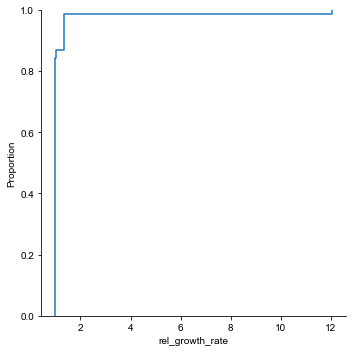

In [28]:
sns.displot(x='rel_growth_rate',data=gr,kind='ecdf')

In [31]:
gr.to_csv('sgm.iJO1366.pyTFA.glucoseOxygen.76genes.28Oct2021.csv')

In [58]:
gr.sort_values('rel_growth_rate')

,gene_name,growth_rate,rel_growth_rate,mu (relative)
gene,,,,
b2029,gnd,0.823182,0.982320,0.982320
b1852,zwf,0.823183,0.982321,0.982321
b1479,maeA,0.834095,0.995342,0.995342
b3844,fre,0.834902,0.996306,0.996306
b3616,tdh,0.837142,0.998979,0.998979
...,...,...,...,...
b1761,gdhA,1.140422,1.360889,1.360889
b0312,betB,1.140422,1.360889,1.360889
b0386,proC,1.140422,1.360889,1.360889


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74]),
 [Text(0, 0, 'gnd'),
  Text(1, 0, 'zwf'),
  Text(2, 0, 'maeA'),
  Text(3, 0, 'fre'),
  Text(4, 0, 'tdh'),
  Text(5, 0, 'putA'),
  Text(6, 0, 'metF'),
  Text(7, 0, 'gpsA'),
  Text(8, 0, 'gatD'),
  Text(9, 0, 'hcaD'),
  Text(10, 0, 'queF'),
  Text(11, 0, 'uxaB'),
  Text(12, 0, 'paaZ'),
  Text(13, 0, 'srlD'),
  Text(14, 0, 'frmA'),
  Text(15, 0, 'proA'),
  Text(16, 0, 'arnA'),
  Text(17, 0, 'yihU'),
  Text(18, 0, 'patD'),
  Text(19, 0, 'xdhB'),
  Text(20, 0, 'yiaK'),
  Text(21, 0, 'wecC'),
  Text(22, 0, 'ugd'),
  Text(23, 0, 'cysJ'),
  Text(24, 0, 'ydiB'),
  Text(25, 0, 'dmlA'),
  Text(26, 0, 'allD'),
  Text(27, 0, 'wcaG'),
  Text(28, 0, 'mtlD'),
  Text

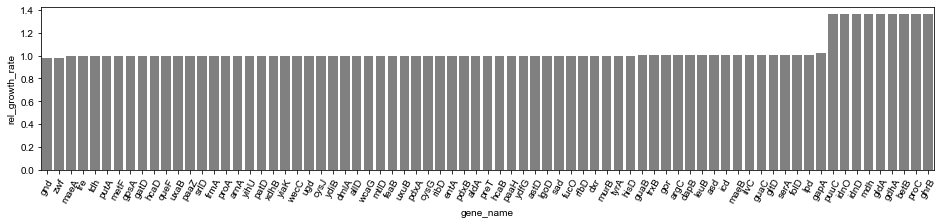

In [46]:
plt.figure(figsize=(16,3))
sns.barplot(x='gene_name',y='rel_growth_rate',data=gr.sort_values('rel_growth_rate').iloc[0:75],color='grey')
plt.xticks(rotation=60)

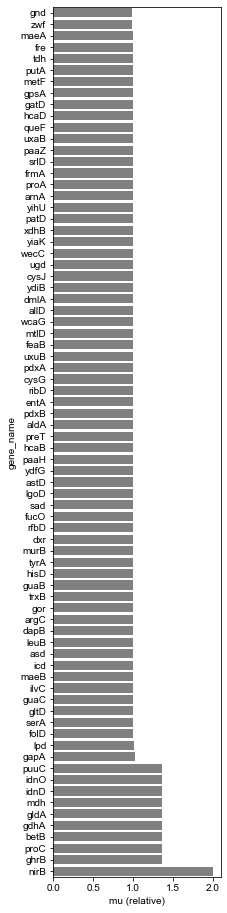

In [55]:
gr['mu (relative)'] = gr['rel_growth_rate'].clip(upper=2)
plt.figure(figsize=(3,16))
sns.barplot(y='gene_name',x='mu (relative)',data=gr.sort_values('rel_growth_rate'),color='grey')
#plt.xticks(rotation=60)
#plt.savefig('barchart.sgm.iJO1366.pyTFA.glucoseOxygen.76genes.28Oct2021.svg')

In [218]:
wt_fluxes = pd.DataFrame(tfa_solution_wt.fluxes)
sc_fluxes = pd.DataFrame(tfa_solution_sc_trimmed.fluxes)
wt_fluxes.columns = ['WT']
sc_fluxes.columns = ['SC']
res = wt_fluxes.join(sc_fluxes)

In [247]:
wt_model_dl = wt_model.copy()

Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmpoocf_1g2.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20304 nonzeros


2021-10-20 09:53:21,494 - thermomodel_RelaxedModel iJO1366[WT] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [248]:
rxn_to_remove = ['GAPD']
wt_model_dl.remove_reactions(rxn_to_remove)

In [249]:
wt_model_dl.slim_optimize()

0.8171423679661247

In [186]:
sc_model_trimmed, removedReactions = removeDuplicateRxn(sc_model)

Read LP format model from file /var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/tmp37gkhr8p.lp
Reading time = 0.02 seconds
: 1805 rows, 5162 columns, 20260 nonzeros


2021-10-19 11:34:50,256 - thermomodel_RelaxedModel iJO1366[NAD] - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [189]:
#removedReactions
tfa_solution_sc_trimmed = sc_model_trimmed.optimize()
tfa_value_sc_trimmed = tfa_solution_sc_trimmed.objective_value
# Report
print('TFA Solution found for SC model : {0:.5g}'.format(tfa_value_sc_trimmed))


TFA Solution found for SC model : 0.72479


In [191]:
tfa_solution_wt.fluxes.to_csv('tfa.wt.fluxes.19Oct2021.csv')
#tfa_solution_sc.fluxes.to_csv('tfa.sc.fluxes.19Oct2021.csv')
tfa_solution_sc_trimmed.fluxes.to_csv('tfa.sc.removedRedundantRxns.fluxes.19Oct2021.csv')


<AxesSubplot:xlabel='WT', ylabel='SC'>

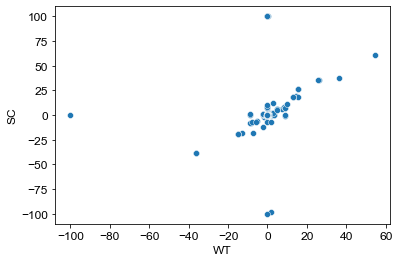

In [219]:
sns.scatterplot(x='WT',y='SC',data=res)
#plt.xlim([-40,40])
#plt.ylim([-40,40])

In [220]:
score = abs(res['WT'] - res['SC'])

In [221]:
subsystem = [wt_model.reactions.get_by_id(x).subsystem for x in score.index.tolist()]

In [222]:
res_score = pd.DataFrame(score,columns=['score']).join(pd.DataFrame(pd.Series(subsystem,index= score.index),columns=['subsystem']))

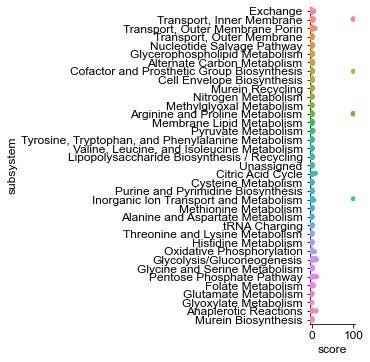

In [224]:
sns.catplot(y='subsystem',x='score',data=res_score)

GALBDtex        0.000000
GLCURtex        0.000000
GLCURt2rpp      0.000000
GLCUR1Ptex      0.000000
QUIN2tpp        0.000000
                 ...    
THRt4pp       100.000000
ASPt2rpp      100.000000
NAt3pp        100.000000
THRt2rpp      100.000000
FADRx         100.061063
Name: score, Length: 2523, dtype: float64

In [185]:
from copy import deepcopy
def removeDuplicateRxn(model):
	model2 = deepcopy(model)
	toRemove = []
	for eachReaction in model2.reactions:

		if eachReaction.id in toRemove:
			continue

		ids = []
		stechiometry = []
		for eachMet in eachReaction.metabolites:
			ids.append(eachMet.id)
			stechiometry.append(eachReaction.metabolites[eachMet])

		removedEachReaction = 0
		for eachReaction2 in model2.reactions:
			if eachReaction2 == eachReaction or eachReaction2.id in toRemove or len(eachReaction2.metabolites) != len(eachReaction.metabolites):
				continue
			
			duplicate = 1
			for eachMet in eachReaction2.metabolites:
			
				if eachMet.id not in ids:
					duplicate = 0
					break
					
				if abs(eachReaction2.metabolites[eachMet]) != abs(stechiometry[ids.index(eachMet.id)]):
					duplicate = 0
					break
			
			if duplicate == 1:
				
				if len(eachReaction2.genes) == 0 and len(eachReaction.genes) == 0:
					if eachReaction2.lower_bound < eachReaction.lower_bound:
						toRemove.append(eachReaction.id)
						removedEachReaction = 1
					else:
						toRemove.append(eachReaction2.id)
				
				elif len(eachReaction2.genes) == 0 and len(eachReaction.genes) != 0:
					toRemove.append(eachReaction.id)
					removedEachReaction = 1
					
				elif len(eachReaction2.genes) != 0 and len(eachReaction.genes) == 0:
					toRemove.append(eachReaction2.id)
				
				elif len(eachReaction2.genes) != 0 and len(eachReaction.genes) != 0:
					
					totalGenes = []
					for eachGene in eachReaction2.genes:
						totalGenes.append(eachGene.id)
					for eachGene in eachReaction.genes:
						if eachGene.id not in totalGenes:
							totalGenes.append(eachGene.id)
				
					if eachReaction2.lower_bound < eachReaction.lower_bound:
						toRemove.append(eachReaction.id)
						if len(eachReaction2.genes) != len(totalGenes):
							string = ''
							for i in range(len(totalGenes)):
								string = string + totalGenes[i]
								if i != len(totalGenes) -1:
									string = string + " or "
							eachReaction2.gene_reaction_rule = '( ' + string +' )'
						removedEachReaction = 1
					else:
						toRemove.append(eachReaction2.id)
						if len(eachReaction.genes) != len(totalGenes):
							string = ''
							for i in range(len(totalGenes)):
								string = string + totalGenes[i]
								if i != len(totalGenes) -1:
									string = string + " or "
							eachReaction.gene_reaction_rule = '( ' + string +' )'
							
				
			if removedEachReaction == 1:
				break
		

	model2.remove_reactions(toRemove)
	
	return [model2, toRemove]